In [2]:
import requests
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import io
import csv

In [3]:
data_path = '/home/gonzalez/Desktop/age_gender/age_gender.csv'
url = 'https://www.kaggle.com/code/shahraizanwar/age-gender-ethnicity-prediction/data?select=age_gender.csv'

In [5]:
data = pd.read_csv(data_path)

In [4]:
data.columns

Index(['age', 'ethnicity', 'gender', 'img_name', 'pixels'], dtype='object')

# Loading data from google cloud to google colab

In [14]:
from google.colab import drive 
drive.mount('/content/gdrive')
df=pd.read_csv('gdrive/My Drive/age_gender.csv')

 # Transforming the pixels data type into a list of float

In [ ]:
# images =[]
# for fotos in range(len(data['pixels'])):
#     X = data['pixels'][fotos].split(" ")
#     X = list(map(int, X))
#     images.append(X)

In [ ]:
# x = np.reshape(images[5000], (48,48))

In [78]:
data['pixels']=data['pixels'].apply(lambda x:  np.array(x.split(), dtype="float32"))

In [79]:
blob = data['pixels'][0].reshape(48,48)

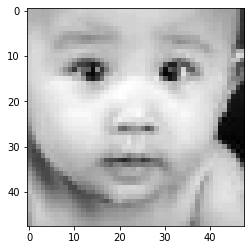

In [80]:
plt.imshow(blob, cmap='gray');

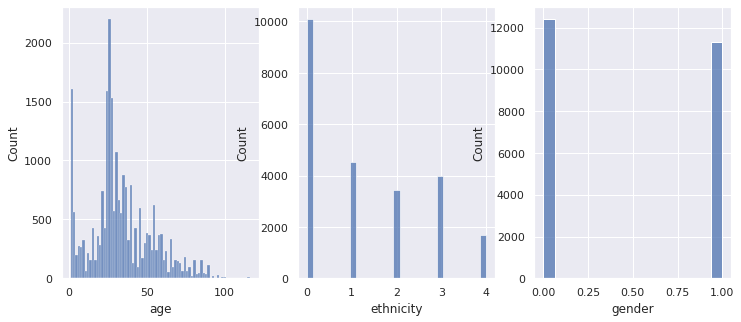

In [33]:
#sns.displot(data['ethnicity']),
#sns.displot(data['gender']), 
#sns.displot(data['age']);
fig, axes = plt.subplots(1, 3, figsize=(12, 5))
sns.histplot(ax=axes[0], x=data['age']);
sns.histplot(ax=axes[1], x=data['ethnicity']);
sns.histplot(ax=axes[2], x=data['gender']);

# Working with the age

In [82]:
# list the number of counts per age
ages = data['age'].unique()
counts = []
for age in ages:
    counts.append(np.count_nonzero(data['age']==age))
    

In [90]:
# table with the first 15 most dense samples regarding age
type(ages), type(counts)
s =pd.DataFrame([ages.T, np.array(counts).T],['ages', 'counts'])
s=s.transpose()
more_dense = s.sort_values(by=['counts'], ascending=False)
more_dense.head(15)

,ages,counts
26,26,2197
0,1,1123
28,28,918
36,35,880
24,24,859
25,25,734
31,30,724
33,32,664
27,27,615
29,29,570


# Function for transforming data numbers into data range classification

In [ ]:
# categorize age per range:
def age_categorize(input_list, age_step=10):
    '''
    Enter the list of age into input_list and the age steps
    with : age_step = 5;  age = 4   =>  1-5
                          age = 12  =>  10-15                        
    '''
    
    cat_age = []
    for age in input_list:
        
        a = float(age)/float(age_step)
        
        if a > 1:
            entero = int(a)
            coma = a-entero
            
            if coma > 0:
                entero = entero+1
            
            max = entero * age_step
            min = max-(age_step-1)     
            cat_age.append(f'{min} to {max}')
        else:
            min = 1
            max = age_step
            cat_age.append(f'{min} to {max}')
            
    return cat_age

In [ ]:
step_size = 3
input_list = data['age']
cat = age_categorize(input_list)

In [ ]:
pd.DataFrame(cat, data['age'].values).sample(100)

In [ ]:
input_list = data['age'].unique

In [ ]:
data['ethnicity'].unique()

# Here we go with the model

In [92]:
from tensorflow.keras import Sequential, layers, models
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from sklearn.model_selection import train_test_split

In [93]:
X = data['pixels'].tolist()
X = np.reshape(X, (-1, 48, 48,1))

y = data['age']

In [94]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [95]:
def initialize_model():
    
    model = Sequential()
    model.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=(48,48,1)))
    model.add(layers.MaxPool2D(pool_size=(2,2)))

    model.add(layers.Conv2D(64, (3,3), activation='relu', padding='same'))
    model.add(layers.MaxPool2D(pool_size=(2,2)))

    
    
    model.add(layers.Conv2D(64,(3,3),activation='relu'))
    model.add(layers.MaxPooling2D(2,2))
    model.add(layers.Dropout(0.2))

    model.add(layers.Conv2D(128,(3,3),activation='relu'))
    model.add(layers.MaxPooling2D(2,2))
    model.add(layers.Dropout(0.2))          

    model.add(layers.Flatten())
    model.add(layers.Dropout(0.5))
    
    model.add(layers.Dense(1, activation='relu'))

    
    return model

In [96]:
model = initialize_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 23, 23, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 23, 23, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 11, 11, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 9, 9, 64)          36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 4, 4, 64)         0

2022-05-31 11:14:27.586696: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/gonzalez/TOOLS/elmer/install//lib
2022-05-31 11:14:27.586721: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-05-31 11:14:27.586740: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (gonzalez-Latitude): /proc/driver/nvidia/version does not exist
2022-05-31 11:14:27.587189: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [97]:
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])

In [99]:
from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)

In [100]:
X_train.shape

(16593, 48, 48, 1)

In [101]:
history = model.fit(X_train, y_train, epochs=40, callbacks=[es])

Epoch 1/40
519/519 [==============================] - 23s 43ms/step - loss: 408.2867 - mae: 15.5040
Epoch 2/40
519/519 [==============================] - 22s 43ms/step - loss: 251.7399 - mae: 11.9026
Epoch 3/40
519/519 [==============================] - 24s 47ms/step - loss: 223.5397 - mae: 11.1481
Epoch 4/40
519/519 [==============================] - 25s 49ms/step - loss: 197.6201 - mae: 10.4441
Epoch 5/40
519/519 [==============================] - 22s 42ms/step - loss: 185.9484 - mae: 10.0802
Epoch 6/40
519/519 [==============================] - 20s 38ms/step - loss: 175.4526 - mae: 9.8085
Epoch 7/40
519/519 [==============================] - 20s 38ms/step - loss: 164.3824 - mae: 9.4989
Epoch 8/40
519/519 [==============================] - 20s 38ms/step - loss: 161.9035 - mae: 9.3788
Epoch 9/40
519/519 [==============================] - 22s 42ms/step - loss: 156.7512 - mae: 9.2185
Epoch 10/40
519/519 [==============================] - 25s 47ms/step - loss: 148.8609 - mae: 8.9956
Epoc

Epoch 28/40
519/519 [==============================] - 26s 51ms/step - loss: 109.7057 - mae: 7.7600
Epoch 29/40
519/519 [==============================] - 26s 50ms/step - loss: 111.2718 - mae: 7.8507
Epoch 30/40
519/519 [==============================] - 23s 44ms/step - loss: 107.6901 - mae: 7.6962
Epoch 31/40
519/519 [==============================] - 22s 43ms/step - loss: 105.5431 - mae: 7.6338
Epoch 32/40
519/519 [==============================] - 23s 45ms/step - loss: 103.6919 - mae: 7.5558
Epoch 33/40
519/519 [==============================] - 23s 45ms/step - loss: 102.9769 - mae: 7.5292
Epoch 34/40
519/519 [==============================] - 23s 44ms/step - loss: 101.1014 - mae: 7.4623
Epoch 35/40
519/519 [==============================] - 26s 50ms/step - loss: 101.0798 - mae: 7.4780
Epoch 36/40
519/519 [==============================] - 26s 50ms/step - loss: 98.9622 - mae: 7.4299
Epoch 37/40
519/519 [==============================] - 31s 59ms/step - loss: 97.6282 - mae: 7.3288
Ep

In [102]:
history.__dict__

{'validation_data': None,
 'model': <keras.engine.sequential.Sequential at 0x7fddca3338e0>,
 '_chief_worker_only': None,
 '_supports_tf_logs': False,
 'history': {'loss': [408.2867431640625,
   251.7398681640625,
   223.53965759277344,
   197.6200714111328,
   185.94837951660156,
   175.45260620117188,
   164.38243103027344,
   161.90345764160156,
   156.75115966796875,
   148.86090087890625,
   144.360107421875,
   140.26434326171875,
   141.6856231689453,
   134.8894500732422,
   132.31358337402344,
   135.40377807617188,
   132.92929077148438,
   123.99063873291016,
   123.84734344482422,
   123.1573715209961,
   121.1749038696289,
   122.0431137084961,
   121.05704498291016,
   118.01837158203125,
   112.39604187011719,
   111.71586608886719,
   111.01199340820312,
   109.70573425292969,
   111.27180480957031,
   107.69005584716797,
   105.5430908203125,
   103.69194030761719,
   102.97689819335938,
   101.10137176513672,
   101.07984161376953,
   98.96221160888672,
   97.628219604

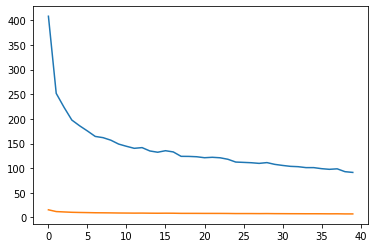

In [105]:
plt.plot(history.history['loss']);
plt.plot(history.history['mae']);

In [106]:
models.save_model(model, 'Model48')

2022-05-31 11:33:37.549005: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: Model48/assets


In [107]:
model.evaluate(X_test,y_test)

223/223 [==============================] - 3s 11ms/step - loss: 109.1943 - mae: 7.4758


[109.19430541992188, 7.475760459899902]

45

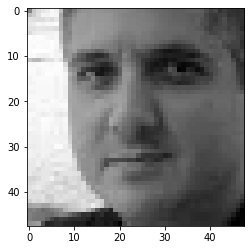

In [139]:
n=230
plt.imshow(X_test[n], cmap='gray');
y_test.iloc[n]

In [135]:
out= model.predict(X_test)

In [140]:
out[n]

array([37.468025], dtype=float32)

In [133]:
np.shape(X_test), np.shape(X_test[0])

((7112, 48, 48, 1), (48, 48, 1))